Class 0: 361
Class 1: 74
Class 2: 200
Class 3: 39
Class 4: 59
Sampled class counts in one epoch:
Class 0: 598
Class 1: 576
Class 2: 607
Class 3: 579
Class 4: 569
Epoch [1/10], Loss: 1.2191, Accuracy: 52.20%, Recall: 0.51, Precision: 0.50, Specificity: 0.88, F1-Score: 0.50
Epoch [2/10], Loss: 0.9357, Accuracy: 62.34%, Recall: 0.62, Precision: 0.61, Specificity: 0.91, F1-Score: 0.61
Epoch [3/10], Loss: 0.8156, Accuracy: 66.75%, Recall: 0.67, Precision: 0.66, Specificity: 0.92, F1-Score: 0.66
Epoch [4/10], Loss: 0.7432, Accuracy: 71.01%, Recall: 0.71, Precision: 0.70, Specificity: 0.93, F1-Score: 0.70
Epoch [5/10], Loss: 0.6774, Accuracy: 74.12%, Recall: 0.74, Precision: 0.73, Specificity: 0.94, F1-Score: 0.74
Epoch [6/10], Loss: 0.5974, Accuracy: 77.40%, Recall: 0.77, Precision: 0.77, Specificity: 0.94, F1-Score: 0.77
Epoch [7/10], Loss: 0.5716, Accuracy: 78.76%, Recall: 0.79, Precision: 0.79, Specificity: 0.95, F1-Score: 0.79
Epoch [8/10], Loss: 0.5248, Accuracy: 80.10%, Recall: 0.80, P

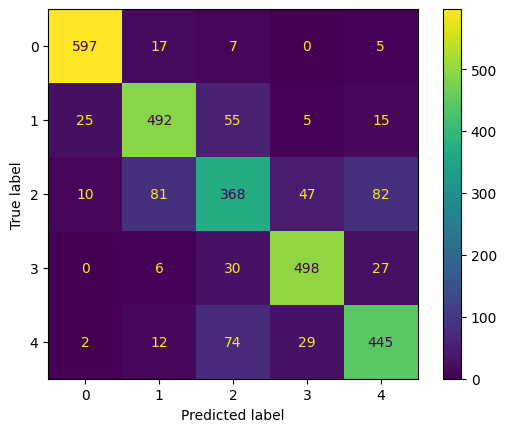

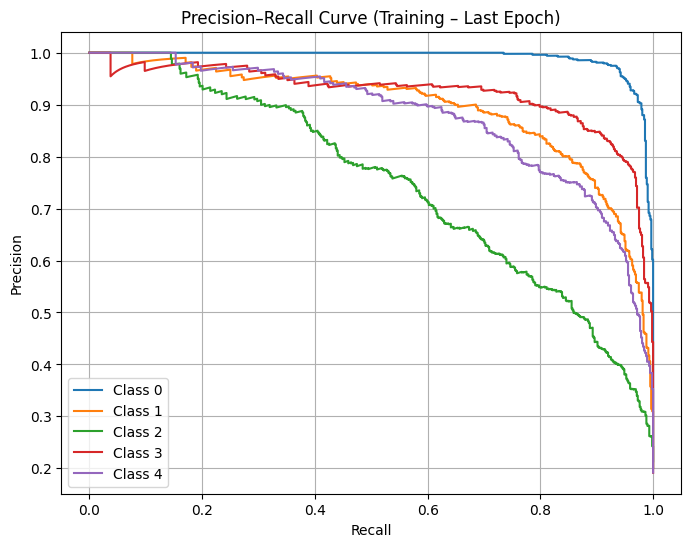

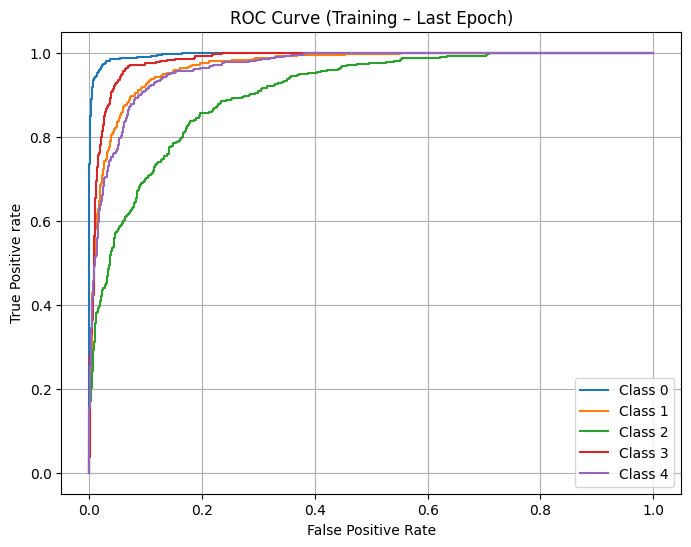

Test Accuracy: 76.13%, Recall: 0.61, Precision: 0.60, Specificity: 0.94, F1-Score: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       361
           1       0.46      0.66      0.54        74
           2       0.74      0.62      0.68       200
           3       0.35      0.46      0.40        39
           4       0.48      0.37      0.42        59

    accuracy                           0.76       733
   macro avg       0.60      0.61      0.60       733
weighted avg       0.78      0.76      0.76       733



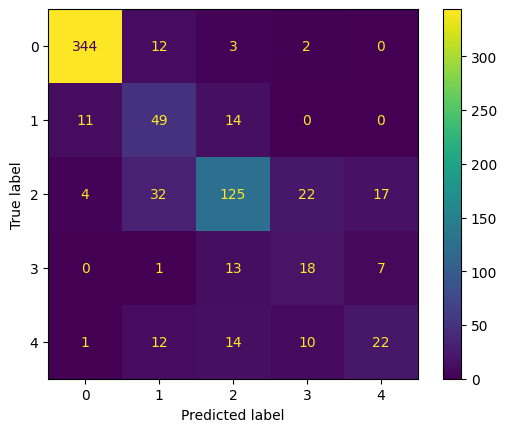

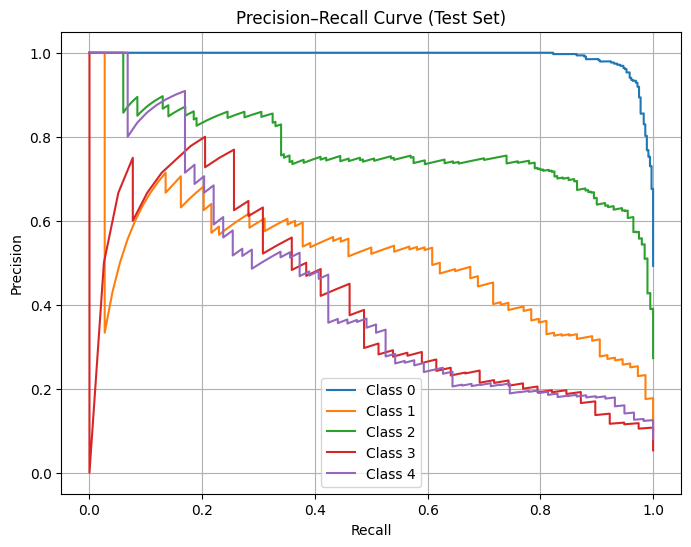

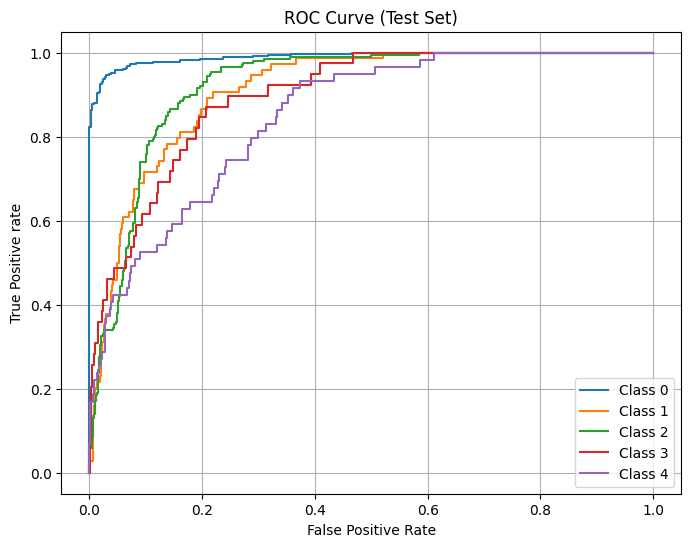

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        img_path = img_path + ".png"
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/APTOS_2019/train.csv"
img_dir = "/mnt/c/Users/matth/CS408/APTOS_2019/train_images"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load MobileNetV2

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = torch.nn.Linear(
    in_features=model.classifier[-1].in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

Class 0: 361
Class 1: 74
Class 2: 200
Class 3: 39
Class 4: 59
Sampled class counts in one epoch:
Class 0: 557
Class 1: 606
Class 2: 629
Class 3: 547
Class 4: 590
Epoch [1/10], Loss: 0.9826, Accuracy: 60.91%, Recall: 0.61, Precision: 0.60, Specificity: 0.90, F1-Score: 0.60
Epoch [2/10], Loss: 0.5828, Accuracy: 78.01%, Recall: 0.77, Precision: 0.77, Specificity: 0.95, F1-Score: 0.77
Epoch [3/10], Loss: 0.4130, Accuracy: 85.63%, Recall: 0.86, Precision: 0.86, Specificity: 0.96, F1-Score: 0.86
Epoch [4/10], Loss: 0.2893, Accuracy: 90.06%, Recall: 0.90, Precision: 0.90, Specificity: 0.98, F1-Score: 0.90
Epoch [5/10], Loss: 0.2102, Accuracy: 93.04%, Recall: 0.93, Precision: 0.93, Specificity: 0.98, F1-Score: 0.93
Epoch [6/10], Loss: 0.1818, Accuracy: 94.64%, Recall: 0.95, Precision: 0.95, Specificity: 0.99, F1-Score: 0.95
Epoch [7/10], Loss: 0.1412, Accuracy: 95.60%, Recall: 0.96, Precision: 0.96, Specificity: 0.99, F1-Score: 0.96
Epoch [8/10], Loss: 0.1156, Accuracy: 96.42%, Recall: 0.96, P

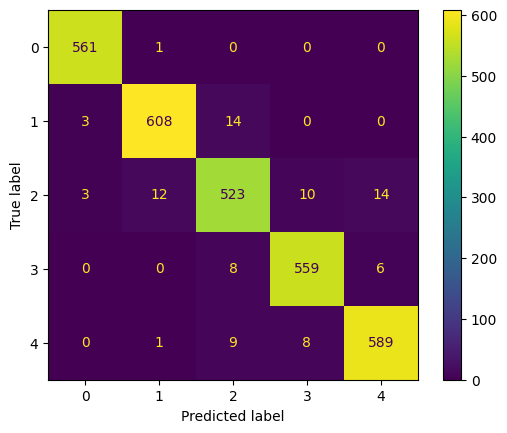

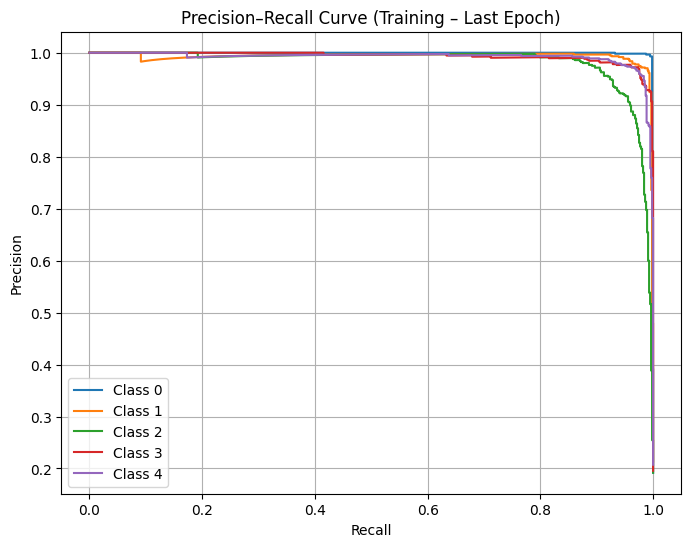

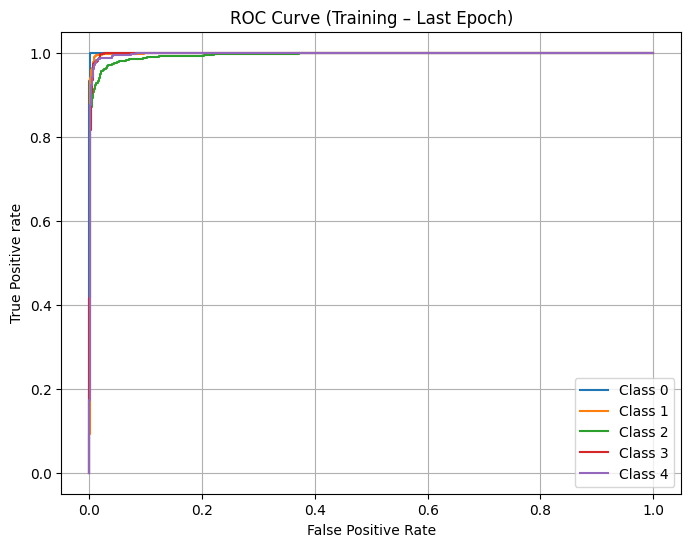

Test Accuracy: 80.35%, Recall: 0.61, Precision: 0.65, Specificity: 0.95, F1-Score: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       361
           1       0.52      0.41      0.45        74
           2       0.71      0.84      0.77       200
           3       0.46      0.31      0.37        39
           4       0.60      0.53      0.56        59

    accuracy                           0.80       733
   macro avg       0.65      0.61      0.62       733
weighted avg       0.79      0.80      0.80       733



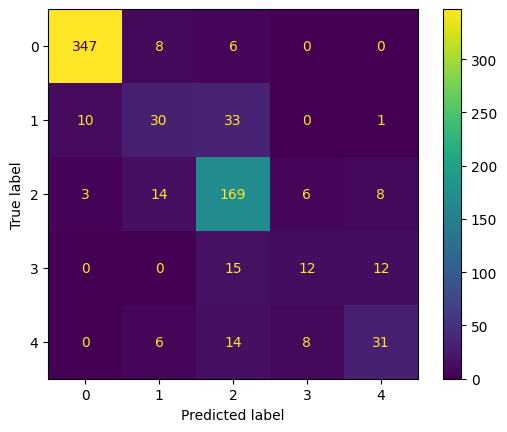

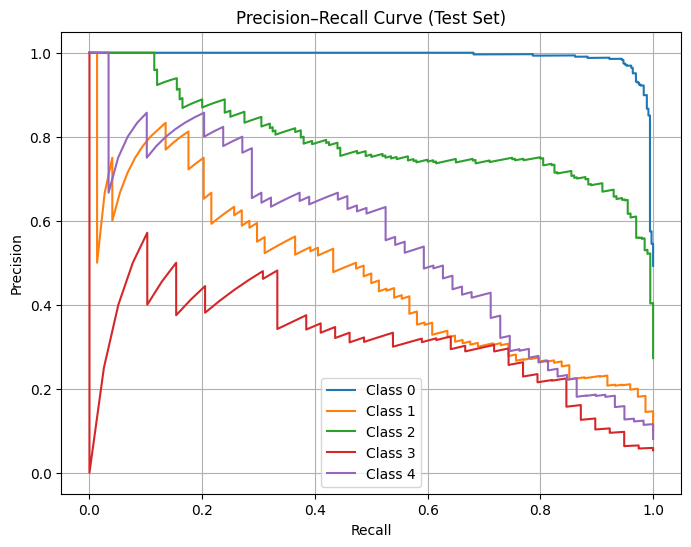

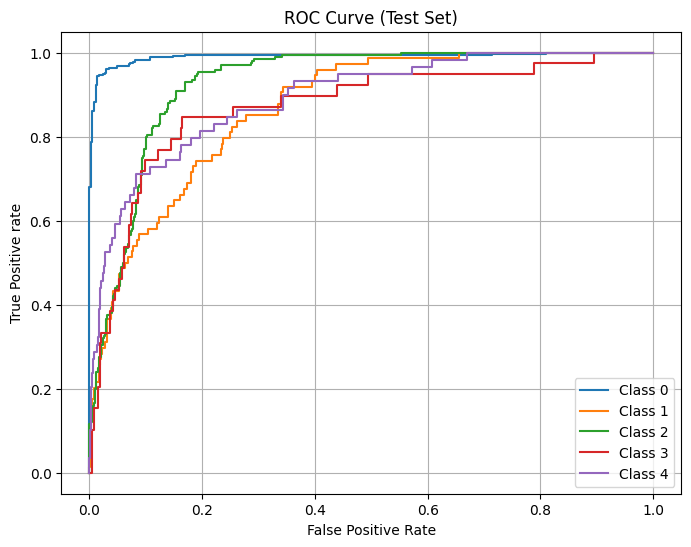

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        img_path = img_path + ".png"
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/APTOS_2019/train.csv"
img_dir = "/mnt/c/Users/matth/CS408/APTOS_2019/train_images"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

Class 0: 361
Class 1: 74
Class 2: 200
Class 3: 39
Class 4: 59
Sampled class counts in one epoch:
Class 0: 595
Class 1: 569
Class 2: 604
Class 3: 571
Class 4: 590
Epoch [1/10], Loss: 0.9463, Accuracy: 60.26%, Recall: 0.59, Precision: 0.59, Specificity: 0.90, F1-Score: 0.59
Epoch [2/10], Loss: 0.5818, Accuracy: 77.71%, Recall: 0.78, Precision: 0.77, Specificity: 0.94, F1-Score: 0.78
Epoch [3/10], Loss: 0.3896, Accuracy: 85.18%, Recall: 0.85, Precision: 0.85, Specificity: 0.96, F1-Score: 0.85
Epoch [4/10], Loss: 0.2708, Accuracy: 90.65%, Recall: 0.91, Precision: 0.91, Specificity: 0.98, F1-Score: 0.91
Epoch [5/10], Loss: 0.2066, Accuracy: 92.69%, Recall: 0.93, Precision: 0.93, Specificity: 0.98, F1-Score: 0.93
Epoch [6/10], Loss: 0.1522, Accuracy: 95.22%, Recall: 0.95, Precision: 0.95, Specificity: 0.99, F1-Score: 0.95
Epoch [7/10], Loss: 0.1458, Accuracy: 94.98%, Recall: 0.95, Precision: 0.95, Specificity: 0.99, F1-Score: 0.95
Epoch [8/10], Loss: 0.1107, Accuracy: 96.89%, Recall: 0.97, P

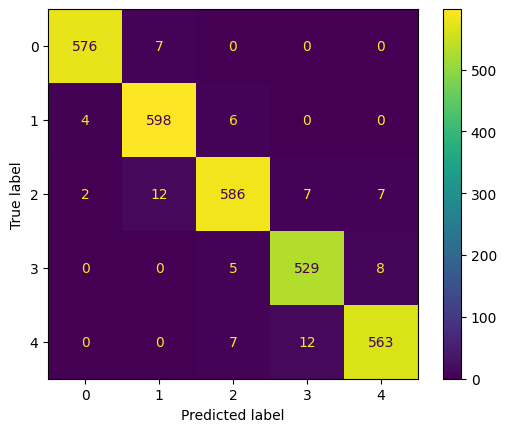

Test Accuracy: 82.95%, Recall: 0.63, Precision: 0.72, Specificity: 0.95, F1-Score: 0.66
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       361
           1       0.66      0.50      0.57        74
           2       0.72      0.89      0.80       200
           3       0.59      0.33      0.43        39
           4       0.64      0.47      0.54        59

    accuracy                           0.83       733
   macro avg       0.72      0.63      0.66       733
weighted avg       0.82      0.83      0.82       733



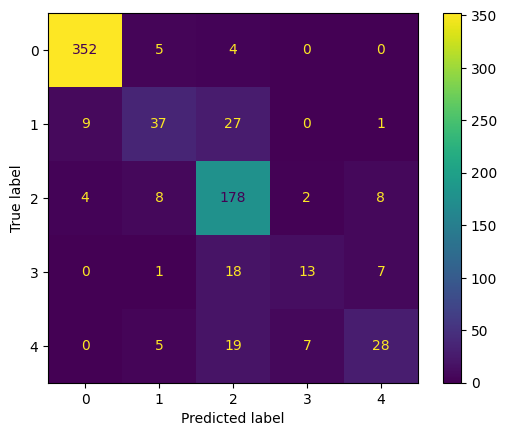

In [3]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from collections import Counter

# Image transformer

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        img_path = img_path + ".png"
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/APTOS_2019/train.csv"
img_dir = "/mnt/c/Users/matth/CS408/APTOS_2019/train_images"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = torch.nn.Linear(
    in_features=model.classifier[-1].in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
pred_val = np.array([])
all_labels = np.array([])
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            pred_val = np.append(pred_val, predicted)
            all_labels = np.append(all_labels, labels)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
pred_val = np.array([])
all_labels = np.array([])

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        pred_val = np.append(pred_val, predicted)
        all_labels = np.append(all_labels, labels)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()